In [1]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional settings
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)


Matplotlib is building the font cache; this may take a moment.


In [2]:
#loading the dataset
df = pd.read_excel("../data/online_retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#shape and columns
df.shape
df.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
#info and description
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
#drop missing customer IDs
df = df.dropna(subset=['CustomerID'])
print("After dropping missing CustomerIDs:", df.shape)

After dropping missing CustomerIDs: (406829, 8)


In [6]:
#remove canceled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print("After removing canceled transactions:", df.shape)


After removing canceled transactions: (397924, 8)


In [7]:
#remove negative quantities
df = df[df['Quantity'] > 0]
print("After removing negative quantities:", df.shape)

After removing negative quantities: (397924, 8)


In [8]:
#remove invalid unit prices
df = df[df['UnitPrice'] > 0]
print("After removing invalid unit prices:", df.shape)

After removing invalid unit prices: (397884, 8)


In [9]:
#drop duplicate rows
df = df.drop_duplicates()
print("After dropping duplicates:", df.shape)

After dropping duplicates: (392692, 8)


In [10]:
#feature engineering - total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()

,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [11]:
#feature engineering - invoice month 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) #incase data not paresed
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df[['InvoiceDate', 'InvoiceMonth']].head()

,InvoiceDate,InvoiceMonth
0,2010-12-01 08:26:00,2010-12
1,2010-12-01 08:26:00,2010-12
2,2010-12-01 08:26:00,2010-12
3,2010-12-01 08:26:00,2010-12
4,2010-12-01 08:26:00,2010-12


In [12]:
#convert customer ID to string
df['CustomerID'] = df['CustomerID'].astype(str)

In [13]:
#save the cleaned dataset
print("Saving cleaned dataset...")
df.to_csv('../data/online_retail_cleaned.csv', index=False)


Saving cleaned dataset...


In [14]:
#final check 
print("✅ Cleaned dataset shape:", df.shape)
print("🧍 Unique customers:", df['CustomerID'].nunique())
print("📅 Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())
# --- IGNORE ---

✅ Cleaned dataset shape: (392692, 10)
🧍 Unique customers: 4338
📅 Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


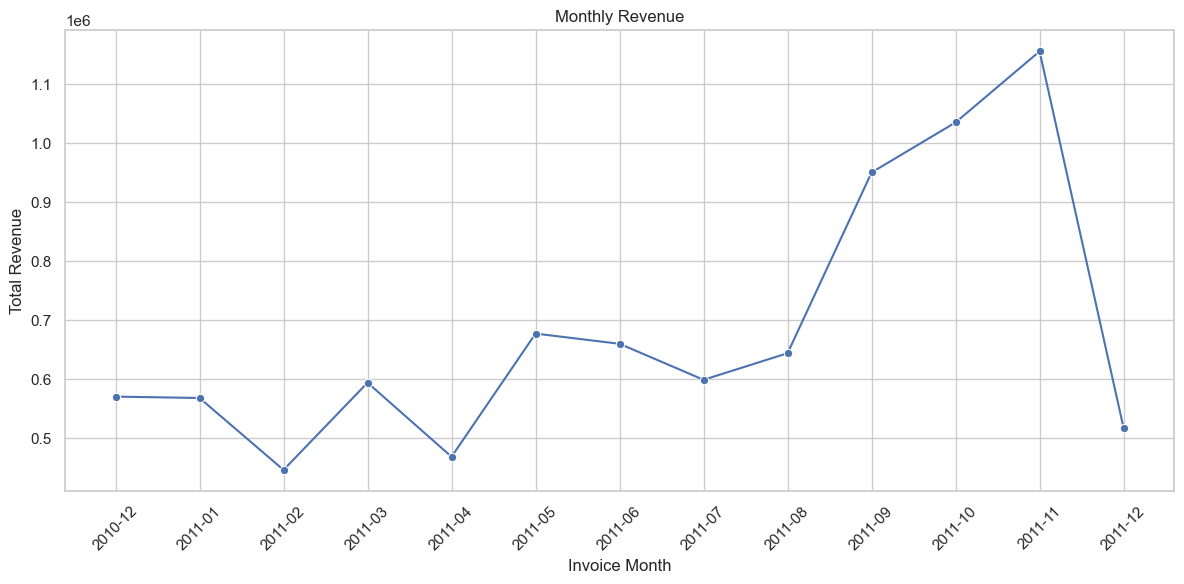

In [16]:
#revenue by month
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
#convert period to string
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceMonth', y='TotalPrice', data=monthly_revenue, marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Invoice Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/gr/6bjwhq7n5cq2ynzxl6qbpcyh0000gn/T/ipykernel_58869/3499061542.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalPrice', y='Description', data=top_products, palette='viridis')


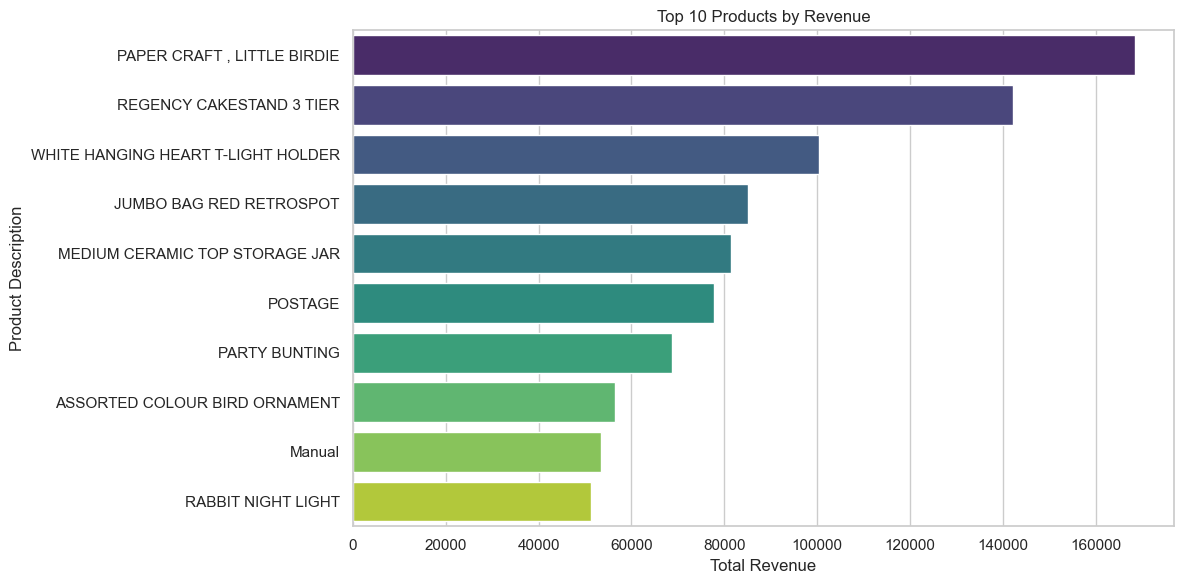

In [17]:
#top products by revenue
top_products = df.groupby('Description')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalPrice', y='Description', data=top_products, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

/var/folders/gr/6bjwhq7n5cq2ynzxl6qbpcyh0000gn/T/ipykernel_58869/2223364836.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Description', data=top_products_quantity, palette='magma')


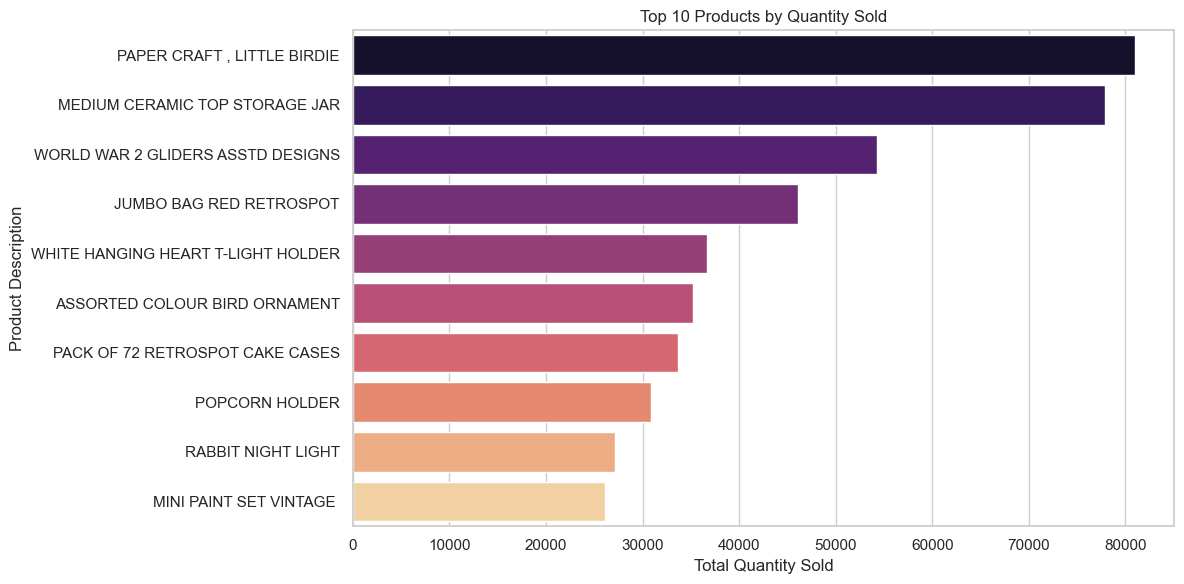

In [18]:
#top 10 products by quantity sold
top_products_quantity = df.groupby('Description')['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', data=top_products_quantity, palette='magma')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

/var/folders/gr/6bjwhq7n5cq2ynzxl6qbpcyh0000gn/T/ipykernel_58869/988880352.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalPrice', y='Country', data=country_revenue, palette='coolwarm')


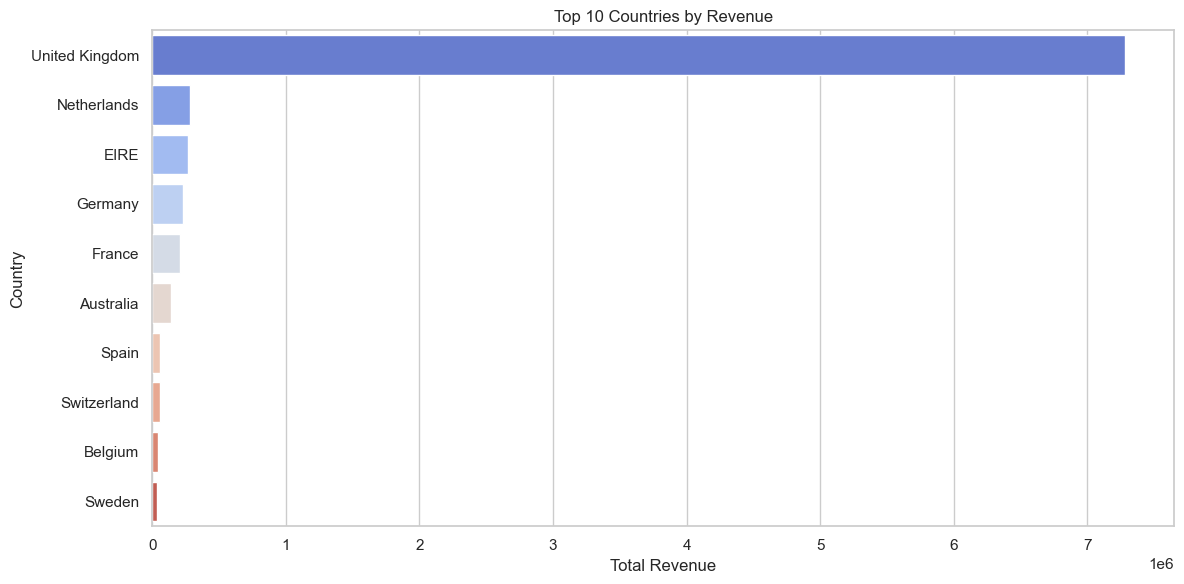

In [19]:
#revenue by country
country_revenue = df.groupby('Country')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalPrice', y='Country', data=country_revenue, palette='coolwarm')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [ ]:
# Revenue per customer
customer_revenue = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)

# Quartiles (Q1, Median, Q3)
quartiles = customer_revenue.quantile([0.25, 0.5, 0.75])
print("Customer Revenue Quartiles:\n", quartiles)

# Calculate 80th percentile (top 20% cutoff)
top_20_cutoff = customer_revenue.quantile(0.80)

# Total revenue from top 20% customers
top_20_revenue = customer_revenue[customer_revenue >= top_20_cutoff].sum()
total_revenue = customer_revenue.sum()

# Print result
print("Top 20% of customers contributed {:.2f}% of revenue".format(100 * top_20_revenue / total_revenue))


Customer Revenue Quartiles:
 0.25     306.4825
0.50     668.5700
0.75    1660.5975
Name: TotalPrice, dtype: float64


AttributeError: 'Series' object has no attribute 'quartiles'